# Lab4 (Students version): robustness of a graph 

We can use the following libraries.

In [1]:
import matplotlib.pyplot as plt
import math
import sys
from random import *
from collections import deque
import copy
import heapq
import tqdm
import collections
print(sys.version)

3.11.6 (main, Oct  2 2023, 20:46:14) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In this lab session, we investigate the notion of robustness of a graph: how well a graph remains connected when nodes disappear following random failures or degree-based failures.

## Exercise 1: preliminary work

### Question 1

Using the code seen in previous labs, load the following graph as a dictonary of lists:

http://lioneltabourier.fr/documents/inet.txt

In [2]:
def read_graph_edges(filename):
    '''Just gets the edges as a list, not currenly used and replaced with "read_graph_dict"'''
    edges = set()

    with open(filename, "r") as f:
        for line in f.readlines():
            if line.startswith("#"): continue
            line = line.strip().replace("\t", " ")
            tuplee = line.split(" ")
            from_id, to_id = int(tuplee[0]), int(tuplee[1])
 
            edges.add([from_id, to_id])

    return list(edges)

def read_graph_dict(filename, undirected=True):
    '''Delete the duplicate edges and load them to memory, unidirected=True adds two way connections'''
    graph_dict = {}
    visited_edges = set()

    def register_to_dict(graph, node):
        if node not in graph:
            graph[node] = []

    def add_connection(graph, from_node, to_node):
        graph[from_node].append(to_node)

    with open(filename, "r") as f:
        for line in f.readlines():
            if line.startswith("#"): continue
            line = line.strip().replace("\t", " ")
            tuplee = line.split(" ")
            from_id, to_id = int(tuplee[0]), int(tuplee[1])

            register_to_dict(graph_dict, from_id)
            register_to_dict(graph_dict, to_id)

            tttt = tuple(sorted([from_id, to_id]))

            if tttt in visited_edges:
                continue
            elif from_id == to_id: 
                continue

            visited_edges.add(tttt)

            add_connection(graph_dict, from_id, to_id)

            if undirected:
                add_connection(graph_dict, to_id, from_id)

    return graph_dict

def number_of_edges_and_nodes(g: dict[int, list[int]]):
    '''Find number of edges and nodes'''
    node_set = set()
    edge_set = set()

    for from_node, transiton_list in g.items():
        for to_node in transiton_list:
            edge_tuple = tuple(sorted([from_node, to_node]))
            node_set.add(from_node)
            node_set.add(to_node)
            edge_set.add(edge_tuple)
    
    return len(node_set), len(edge_set)

def connected_components(g):
    '''Calculates the connected components. Returns a dict with node ids as keys and component id as values.'''
    node_components =  {}
    unmarked_nodes = {n for n in g.keys()}
    component_id = 0

    # BFS
    while len(unmarked_nodes) != 0:
        s_node = unmarked_nodes.pop()
        queue = [s_node]

        while len(queue) != 0:
            c_node = queue.pop(0)
            node_components[c_node] = component_id

            for adj_node in g[c_node]:
                if adj_node in unmarked_nodes: 
                    unmarked_nodes.remove(adj_node)
                    queue.append(adj_node)

        component_id += 1

    return node_components

def component_counts(node_components: dict[int, int]):
    '''Returns a dict with keys as component id and value as the number of nodes in that component.'''
    component_counts: dict[int, int] = {}
    for _, component_id in node_components.items():
        if component_id not in component_counts: # Add if component not encountered
            component_counts[component_id] = 0
        component_counts[component_id] += 1
    return component_counts

In [3]:
g_inet = read_graph_dict("./inet.txt", undirected=True)

g_inet_edges, g_inet_nodes = number_of_edges_and_nodes(g_inet)
print(f"g_inet has {g_inet_edges} edges and {g_inet_nodes} nodes")

g_inet has 9740 edges and 35567 nodes


### Question 2

Determine the size of the largest connected component (LCC) of a graph, and use the code to determine the size of the LCC of the example graph.

Suggested implementation:

- Create a function that takes a graph as input and outputs a dictionary of the connected component that each node belongs to. (This function is derived from a BFS).

- Then, create another function which takes the dictionary of the connected components as input and computes the size of the largest connected component of the graph.

In [4]:
g_inet_nodecomponents = connected_components(g_inet)
g_inet_cc = component_counts(g_inet_nodecomponents)
print(f"g_inet's largest component has {max(g_inet_cc.values())} element(s)")

g_inet's largest component has 8557 element(s)


## Exercise 2: robustness to random failures

### Question 3

In this question, we plot the size of the LCC as a function of the number of nodes removed. 

Nodes are removed randomly. It is a way to evaluate the robustness of the network to random failures.

Suggested implementation:

- create a function that deletes $n_s$ nodes from the original graph

- use the function of Question 2 to compute the size of the LCC

- combine these two functions and iterate to get a dictionary which keys are $n_s$ and values are the corresponding size of the LCC




In [5]:
def remove_node(g: dict[int, list[int]], node):
    '''Removes nodes and all traces, mutates the given graph'''

    # Removes the outgoing nodes
    if node in g:
        del g[node]
    
    for trans_list in g.values():
        if node not in trans_list: continue
        # Removes the incoming nodes
        trans_list.remove(node)

def remove_unspecified_nodes(g: dict[int, list[int]], specified_nodes: set[int]):
    '''This function removes the nodes that are not specified from the graph'''
    nodes_to_be_removed = set(g.keys()).difference(specified_nodes)

    for node_to_be_removed in nodes_to_be_removed:
        remove_node(g, node_to_be_removed)
        

def nodes_and_llcs(g: dict[int, list[int]]):
    def get_max_component(cc: dict[int, int]):
        largest_component_size, largest_component_id = 0, 0
        for component_id, component_size in cc.items():
            if component_size > largest_component_size:
                largest_component_id = component_id
                largest_component_size = component_size
        return largest_component_size, largest_component_id

    lcc_size_list = []
    g_new = copy.deepcopy(g)

    g_nodecomponents = connected_components(g_new)
    g_cc = component_counts(g_nodecomponents)
    largest_component_size, largest_component_id = get_max_component(g_cc)
    nodes_of_largest_component = {node_id for node_id, com_id in g_nodecomponents.items() if largest_component_id == com_id}
    lcc_size_list.append(largest_component_size)
    remove_unspecified_nodes(g_new, nodes_of_largest_component)

    while nodes_of_largest_component:
        removed_node = nodes_of_largest_component.pop()

        # remove node from the graph
        remove_node(g_new, removed_node)

        # calculate the connected components of the whole graph
        g_nodecomponents = connected_components(g_new)
        g_cc = component_counts(g_nodecomponents)
        largest_component_size, largest_component_id = get_max_component(g_cc)
        nodes_of_largest_component = {node_id for node_id, com_id in g_nodecomponents.items() if largest_component_id == com_id}
        lcc_size_list.append(largest_component_size)
        remove_unspecified_nodes(g_new, nodes_of_largest_component)

        # print(largest_component_size)

    return lcc_size_list

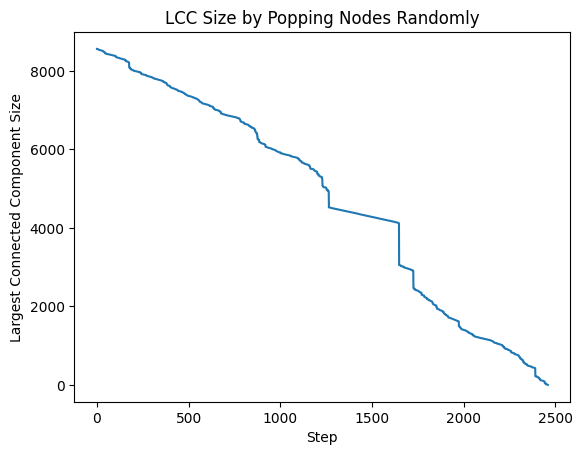

In [6]:
lcc_size_list = nodes_and_llcs(g_inet)
plt.plot(lcc_size_list); plt.title("LCC Size by Popping Nodes Randomly"); plt.xlabel("Step"); plt.ylabel("Largest Connected Component Size"); plt.show()

## Exercise 3: robustness to targeted (degree-based) failures 

### Question 4

In this question, we do the same as in the previous question, except for the fact that nodes are not chosen randomly, but by decreasing degree order.

Suggested implementation:

- create a function that outputs a list of nodes ordered by decreasing degree

- then follow the same principle as in the previous question

In [7]:
def pop_largest_outdegree(g: dict[int, list[int]], node_set: set[int]) -> int:
    '''The node set must contain all the nodes in the graph as keys'''
    if len(g.keys()) <= 1: return
    max_outdegree, max_node = 0, 0
    for current_node, t in g.items():
        if current_node not in node_set: continue
        current_outdegree = len(t)
        if current_outdegree > max_outdegree:
            max_outdegree = current_outdegree
            max_node = current_node

    if max_node not in node_set: 
        return
    node_set.remove(max_node)

    return max_node

def nodes_and_llcs_highest_degree(g: dict[int, list[int]]):
    def get_max_component(cc: dict[int, int]):
        largest_component_size, largest_component_id = 0, 0
        for component_id, component_size in cc.items():
            if component_size > largest_component_size:
                largest_component_id = component_id
                largest_component_size = component_size
        return largest_component_size, largest_component_id

    lcc_size_list = []
    g_new = copy.deepcopy(g)

    g_nodecomponents = connected_components(g_new)
    g_cc = component_counts(g_nodecomponents)
    largest_component_size, largest_component_id = get_max_component(g_cc)
    nodes_of_largest_component = {node_id for node_id, com_id in g_nodecomponents.items() if largest_component_id == com_id}
    lcc_size_list.append(largest_component_size)
    remove_unspecified_nodes(g_new, nodes_of_largest_component)

    while nodes_of_largest_component:
        # instead of popping randomly chose the one with highest degree
        # removed_node = nodes_of_largest_component.pop()
        removed_node = pop_largest_outdegree(g_new, nodes_of_largest_component)

        if not remove_node: 
            break

        # remove node from the graph
        remove_node(g_new, removed_node)

        # calculate the connected components of the whole graph
        g_nodecomponents = connected_components(g_new)
        g_cc = component_counts(g_nodecomponents)
        largest_component_size, largest_component_id = get_max_component(g_cc)
        nodes_of_largest_component = {node_id for node_id, com_id in g_nodecomponents.items() if largest_component_id == com_id}
        lcc_size_list.append(largest_component_size)
        remove_unspecified_nodes(g_new, nodes_of_largest_component)

        if largest_component_size == 1: 
            lcc_size_list.append(1)
            lcc_size_list.append(0)
            break

        # print(largest_component_size)

    return lcc_size_list

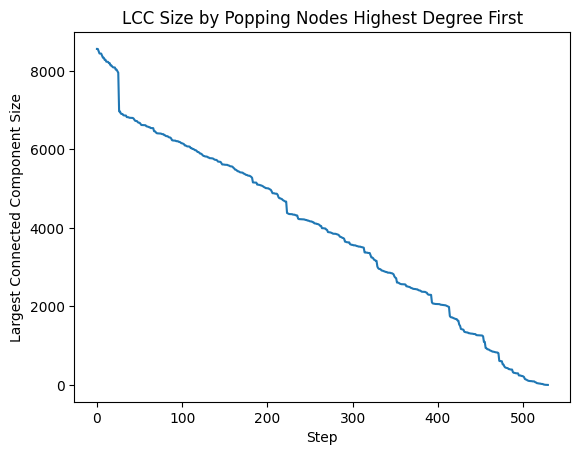

In [8]:
lcc_size_list2 = nodes_and_llcs_highest_degree(g_inet)
plt.plot(lcc_size_list2); plt.title("LCC Size by Popping Nodes Highest Degree First"); plt.xlabel("Step"); plt.ylabel("Largest Connected Component Size"); plt.show()

### Question 5

Compare the two curves (random deletions and targeted deletions): are they different? What does it mean?

## As we learned in the lecture, there is no theoretical proof that the second approach (greedy approach) is better than the first approach. However, in practice we see removing the nodes with higher degrees makes us decompose the graph quickly. This is a valuable heuristic and can be used.

### Question 6

Do the same thing but now with targeted (closeness and betweenness based) failures


In [9]:
def calculate_distances_modified_bfs(g, s, node_set) -> dict[int, int]:
    '''Modifies version of bfs, returnes the distance dict from s to u where u is the key of the dict.'''
    #F is the queue, s is the starting node, visited stands for marked
    visited = set()
    F = [s]
    
    # In some cases there can be edges not located in the graph's keys but in the connection list.
    # The given graph assumed to not satisfy this property.
    # dist = {node: -1 for node in g}
    dist = {}
    
    #dist=[-1] * len(graph)
    dist[s] = 0

    while F:
        node = F.pop(0)
        visited.add(node)

        for neighbor in g[node]:
            if neighbor not in node_set: continue
            if node < neighbor: continue # since we have an undirected graph

            distance_neigbor = -1

            if neighbor in dist:
                distance_neigbor = dist[neighbor]

            if neighbor not in visited and neighbor not in F and distance_neigbor == -1:
                F.append(neighbor)
                dist[neighbor] = dist[node] + 1

    return dist


def remove_node_optimized(g: dict[int, list[int]], node):
    '''Removes nodes and all traces, mutates the given graph'''
    if node not in g: 
        return
    else:
        adj_list = set(g[node])
        del g[node]
    
        # Just remove the nodes 
        for to_node in adj_list:
            if node in g[to_node]:
                g[to_node].remove(node)
            else:
                raise Exception("If you seeing this then your graph is corrupted somehow?")

def remove_unspecified_nodes_optimized(g: dict[int, list[int]], specified_nodes: set[int]):
    '''
        This function removes the nodes that are not specified from the graph.
        Since the graph is unidirectional, we know the incoming nodes as well.
    '''
    nodes_to_be_removed = set(g.keys()).difference(specified_nodes)

    for node_to_be_removed in nodes_to_be_removed:
        remove_node_optimized(g, node_to_be_removed)

def pop_largest_closeness(g: dict[int, list[int]], node_set: set[int], k=1000) -> int:
    '''The node set must contain all the nodes in the graph as keys'''
    if len(g.keys()) <= 1: return
    max_closeness, max_node = 0, 0 # well actually smallest closeness first but words are words

    closeness_dict = {}

    # Maybe we can parallelize here
    for c_node in node_set:
        distance_dict = calculate_distances_modified_bfs(g, c_node, node_set)
        total = 0
        for _, distance in distance_dict.items():
            total += distance
        
        if total != 0:
            closeness_dict[c_node] = 1 / total 
        else:
            closeness_dict[c_node] = 0
            # well pop this node
            node_set.remove(c_node)
            return c_node


    for c_node, current_closeness in closeness_dict.items():
        if current_closeness < max_closeness:
            max_closeness = current_closeness
            max_node = c_node

    if max_node not in node_set: 
        return
    
    node_set.remove(max_node)

    return max_node

def nodes_and_llcs_highest_closeness(g: dict[int, list[int]]):
    def get_max_component(cc: dict[int, int]):
        largest_component_size, largest_component_id = 0, 0
        for component_id, component_size in cc.items():
            if component_size > largest_component_size:
                largest_component_id = component_id
                largest_component_size = component_size
        return largest_component_size, largest_component_id

    lcc_size_list = []
    g_new = copy.deepcopy(g)

    g_nodecomponents = connected_components(g_new)
    g_cc = component_counts(g_nodecomponents)
    largest_component_size, largest_component_id = get_max_component(g_cc)
    nodes_of_largest_component = {node_id for node_id, com_id in g_nodecomponents.items() if largest_component_id == com_id}
    lcc_size_list.append(largest_component_size)
    remove_unspecified_nodes_optimized(g_new, nodes_of_largest_component)

    while nodes_of_largest_component:
        # instead of popping randomly chose the one with highest degree
        # removed_node = nodes_of_largest_component.pop()
        removed_node = pop_largest_closeness(g_new, nodes_of_largest_component)

        if not remove_node: 
            break

        # remove node from the graph
        remove_node(g_new, removed_node)

        # calculate the connected components of the whole graph
        g_nodecomponents = connected_components(g_new)
        g_cc = component_counts(g_nodecomponents)
        largest_component_size, largest_component_id = get_max_component(g_cc)
        nodes_of_largest_component = {node_id for node_id, com_id in g_nodecomponents.items() if largest_component_id == com_id}
        lcc_size_list.append(largest_component_size)
        remove_unspecified_nodes_optimized(g_new, nodes_of_largest_component)

        if largest_component_size == 1: 
            lcc_size_list.append(1)
            lcc_size_list.append(0)
            break

        # print(largest_component_size)

    return lcc_size_list

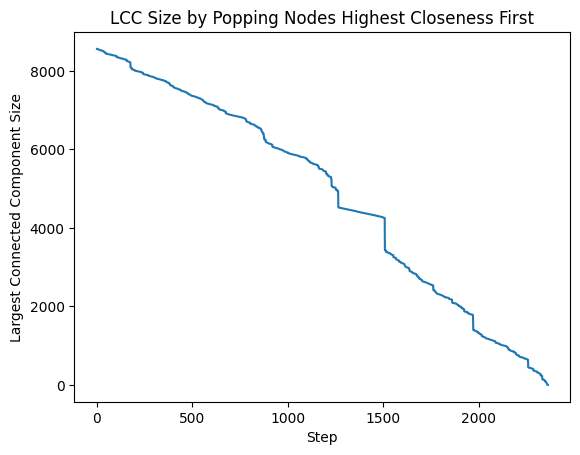

In [10]:
lcc_size_list2 = nodes_and_llcs_highest_closeness(g_inet)
plt.plot(lcc_size_list2); plt.title("LCC Size by Popping Nodes Highest Closeness First"); plt.xlabel("Step"); plt.ylabel("Largest Connected Component Size"); plt.show()

# We have also have a more clear implementation but it was slower, thus we decided to use the first one with some optimizations.

In [11]:
# def compute_distances(g: dict[int, list[int]]):
#     def get(a, b):
#         if a > b:
#             return b, a
#         return a, b

#     distances: dict[tuple[int, int], int] = collections.defaultdict(lambda: float('inf')) # (s, v) -> int

#     for s in tqdm.tqdm(g.keys()):
#         visited = set()
#         F = [s]
#         distances[get(s, s)] = 0 # self distance is always 0

#         while F:
#             vertex = F.pop(0)
#             visited.add(vertex)

#             # Iterate through the adjs of v
#             for u in g[vertex]:
#                 if u in visited: continue

#                 if distances[get(s, u)] > distances[get(s, vertex)] + 1:
#                     distances[get(s, u)] = distances[get(s, vertex)] + 1

#                 F.append(u)  

#     return distances

# def select_based_on_closeness(g, lcc_nodes: set[int]) -> set[int]:
#     '''Calculates the distances'''
#     def get(a, b):
#         if a > b:
#             return b, a
#         return a, b
#     e = lcc_nodes.pop()
#     lcc_nodes.add(e)

#     # O(n^2)
#     distances = compute_distances(g)


#     return {e}

# def get_lcc_nodes(g) -> set[int]:
#     '''Gets set of nodes belonging to the largest connected component in the graph g. OPTIMIZED.'''
#     node_components =  {} # node_id -> component_id
#     unmarked_nodes = {n for n in g.keys()}
#     component_id = 0

#     max_component_id, max_component_size = 0, 0

#     # BFS
#     while len(unmarked_nodes) != 0:
#         s_node = unmarked_nodes.pop()
#         queue = [s_node]
#         current_component_size = 0 # start with component_size = 0

#         while len(queue) != 0:
#             c_node = queue.pop(0)
#             node_components[c_node] = component_id
#             current_component_size += 1

#             for adj_node in g[c_node]:
#                 if adj_node in unmarked_nodes: 
#                     unmarked_nodes.remove(adj_node)
#                     queue.append(adj_node)

#         if max_component_size < current_component_size:
#             max_component_size = current_component_size
#             max_component_id = component_id
#         component_id += 1

#     return {n_id for n_id, c_id in node_components.items() if c_id == max_component_id}

# def decrease_lcc(g: dict[int, list[int]]):
#     '''k'''
#     def remove_all_except(g: dict[int, list[int]], node_to_keep: set[int]):
#         def remove_from_graph(g: dict[int, list[int]], node):
#             '''Removes nodes and all traces, mutates the given graph'''
#             if node not in g: 
#                 return
#             else:
#                 adj_list = set(g[node])
#                 del g[node]
            
#                 # Just remove the nodes 
#                 for to_node in adj_list:
#                     if node not in g[to_node]: continue # this shouldn't happen
#                     g[to_node].remove(node)
                
#         nodes_to_remove = {n for n in g}.difference(node_to_keep)

#         for node in nodes_to_remove:
#             remove_from_graph(g, node)
#     # Copy the graph
#     g_new = copy.deepcopy(g) # copy g

#     lcc_nodes = get_lcc_nodes(g_new)
#     lcc_size_list = [len(lcc_nodes)]
    
#     while lcc_nodes:
#         print(len(lcc_nodes))
#         # Select the node baseed on the closeness 
#         selected_nodes = select_based_on_closeness(g, lcc_nodes)

#         # Removes the nodes from the lcc_nodes
#         lcc_nodes = lcc_nodes.difference(selected_nodes)

#         # Remove all nodes except the nodes in lcc
#         remove_all_except(g_new, lcc_nodes)

#         # Calculate the lcc_again
#         lcc_nodes = get_lcc_nodes(g_new) 

#         # Add the lcc_size to the list
#         lcc_size_list.append(len(lcc_nodes))

#     return lcc_size_list

In [12]:
# g_inet_lccs = decrease_lcc(g_inet)

# plt.plot(g_inet_lccs)
# plt.title("LCC Size by Popping Nodes Highest Closeness First")
# plt.xlabel("Step")
# plt.ylabel("Largest Connected Component Size")
# plt.show()

### Question 7

Which measure is the fastest one to disconnect the network?


# In practice popping the highest degree node worked very well compared to random removal.